In [31]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers
import keras_tuner as kt

X = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Xp.csv", sep=';')
Y = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_Y.csv", sep=';')
M = pd.read_csv("C:/Users/Administrator/Desktop/PFE/data/new/miscplants_M.csv", sep=';', na_values ='missing')


In [29]:
def split_data(Var):

    if Var not in Y.columns or Var not in M.columns:
        raise ValueError(f"Errer Erreur Erreur ! ! !")

    mask = M[Var]

    # Split X and Y based on M.csv values
    X_cal = X[mask == 'cal']
    Y_cal = Y.loc[X_cal.index, Var]

    X_val = X[mask == 'val']
    Y_val = Y.loc[X_val.index, Var]

    X_test = X[mask == 'test']
    Y_test = Y.loc[X_test.index, Var]

    return (X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test)

In [114]:
Var = 'cp'

In [116]:
# Data Splitting
(X_cal, Y_cal), (X_val, Y_val), (X_test, Y_test) = split_data(Var)
Y_train = pd.concat([Y_cal, Y_val])
X_train = pd.concat([X_cal, X_val])

# Convert to NumPy arrays
X_cal = X_cal.to_numpy()
X_val = X_val.to_numpy()
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

num_features = 700  # Spectral features

# Standardization (using X_cal statistics to avoid data leakage)
mean_cal, std_cal = X_cal.mean(), X_cal.std()

X_cal_N = (X_cal - mean_cal) / std_cal
X_val_N = (X_val - mean_cal) / std_cal
X_train_N = (X_train - mean_cal) / std_cal
X_test_N = (X_test - mean_cal) / std_cal

# Reshape for 1D CNN (batch_size, sequence_length, channels) (taille du batch,longueur de la séquence,canaux)
X_cal_f = X_cal_N[..., np.newaxis]  # Shape: (samples, features, 1)
X_val_f = X_val_N[..., np.newaxis]
X_train_f = X_train_N[..., np.newaxis]
X_test_f = X_test_N[..., np.newaxis]

X_cal_f.shape, X_val_f.shape, X_train_f.shape, X_test_f.shape
Y_cal.shape, Y_val.shape, Y_train.shape, Y_test.shape

((880,), (293,), (1173,), (391,))

# old n Simple

In [97]:
def build_cnn():
    model = models.Sequential([
        layers.Conv1D(filters=3, kernel_size=5, activation='relu', padding='same', input_shape=(num_features, 1)),
        layers.MaxPooling1D(pool_size=2),
        # layers.Conv1D(filters=3, kernel_size=5, activation='relu', padding='same'),
        # layers.Conv1D(filters=3, kernel_size=5, activation='relu', padding='same'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    return model

# Learning rate scheduler (exponential decay)
def lr_schedule(epoch, lr):
    return lr #* tf.math.exp(-0.05)  

In [ ]:
model = build_cnn()
initial_lr = 0.001
optimizer = optimizers.Adam(learning_rate=initial_lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

history = model.fit(
    X_cal_f, Y_cal,
    validation_data=(X_val_f, Y_val),
    epochs=100,
    #batch_size=64,
    callbacks=[lr_callback],
    verbose=1
)
# Plot the loss curves
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Calibration Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Calibration vs. Validation Loss Over Epochs')
plt.show()

In [ ]:
model.fit(
    X_train_f, Y_train,
    epochs=150,
    #batch_size=64,
    callbacks=[lr_callback],
    verbose=1
)
Y_pred = model.predict(X_test_f)
Y_pred = Y_pred.flatten()
rmsep = np.sqrt(np.mean((Y_pred - Y_test) ** 2))
print(f'Root Mean Square Error of Prediction (RMSEP): {rmsep:.4f}')

# new

In [117]:
# CNN Model with Hyperparameter Tuning
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv1D(
            filters=hp.Choice('filters', [32, 64, 128]), 
            kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
            activation='relu',
            input_shape=(num_features, 1)
        ),
        keras.layers.MaxPooling1D(pool_size=2),
        # keras.layers.Conv1D(
            # filters=hp.Choice('filters_2', [32, 64, 128]),
            # kernel_size=hp.Choice('kernel_size_2', [3, 5, 7]),
            # activation='relu'
        # ),
        # keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=256, step=32),
            activation='relu'
        ),
        keras.layers.Dense(1, activation='linear')  # cause its a Regression output
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

In [118]:
# Hyperparameter Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',  # Minimize mean absolute error (regression)
    max_trials=10,
    executions_per_trial=1,
    directory='my_tuning',
    project_name=f'cnn2_{Var}'
    # num_initial_points=2,
)


In [119]:
# Start Search
tuner.search(X_train_f, Y_train, epochs=50, validation_data=(X_val_f, Y_val),verbose=1)

Trial 10 Complete [00h 00m 30s]
val_mae: 2.531346082687378

Best val_mae So Far: 0.5923451781272888
Total elapsed time: 00h 08m 20s


In [121]:
# Get Best Model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best filters: {best_hps.get('filters')}")
print(f"Best kernel size: {best_hps.get('kernel_size')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best dense units: {best_hps.get('units')}")

best_model = tuner.hypermodel.build(best_hps)
best_model.summary()


Best filters: 64
Best kernel size: 7
Best learning rate: 0.001
Best dense units: 160
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 694, 64)           512       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 347, 64)           0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 22208)             0         
                                                                 
 dense_4 (Dense)             (None, 160)               3553440   
                                                                 
 dense_5 (Dense)             (None, 1)                 161       
                                                                 
Total params: 3554113 (13.56 MB)
Tr

Epoch 1/200
37/37 [==============================] - 2s 39ms/step - loss: 26.2767 - mae: 3.7717 - val_loss: 8.2991 - val_mae: 1.9919
Epoch 2/200
37/37 [==============================] - 1s 34ms/step - loss: 6.2652 - mae: 1.7572 - val_loss: 4.3070 - val_mae: 1.4510
Epoch 3/200
37/37 [==============================] - 1s 41ms/step - loss: 4.1007 - mae: 1.4613 - val_loss: 3.3451 - val_mae: 1.3425
Epoch 4/200
37/37 [==============================] - 1s 38ms/step - loss: 3.5420 - mae: 1.3700 - val_loss: 3.7203 - val_mae: 1.4400
Epoch 5/200
37/37 [==============================] - 1s 36ms/step - loss: 3.8066 - mae: 1.4566 - val_loss: 4.3046 - val_mae: 1.7134
Epoch 6/200
37/37 [==============================] - 1s 34ms/step - loss: 3.2134 - mae: 1.3010 - val_loss: 2.8346 - val_mae: 1.2338
Epoch 7/200
37/37 [==============================] - 1s 34ms/step - loss: 3.1847 - mae: 1.2921 - val_loss: 2.3444 - val_mae: 1.1261
Epoch 8/200
37/37 [==============================] - 1s 34ms/step - loss: 2

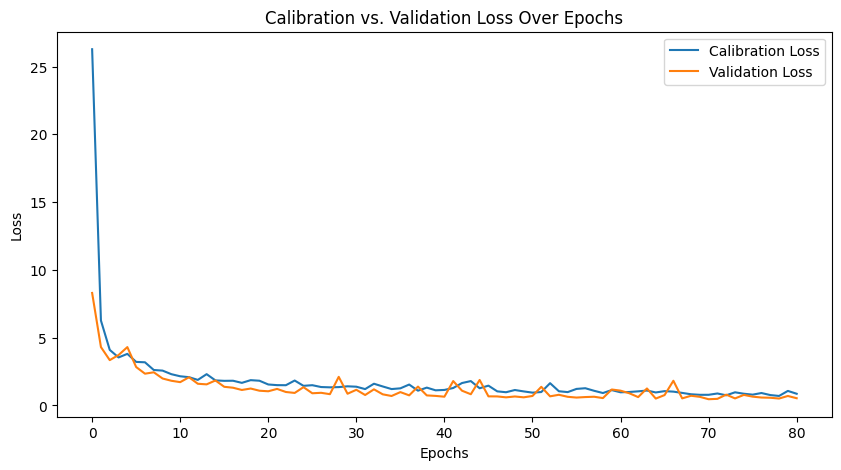

In [122]:
# Define early stopping (optional but useful)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Watch validation loss
    patience=10,         # Stop if no improvement after 20 epochs
    restore_best_weights=True
)

# Train the model while monitoring loss
history = best_model.fit(
    X_train_f, Y_train,
    validation_data=(X_val_f, Y_val),
    epochs=200,  # Large number to observe when overfitting happens
    batch_size=32,
    callbacks=[early_stopping],  # Optional
    verbose=1
)

# Plot the loss curves
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Calibration Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Calibration vs. Validation Loss Over Epochs')
plt.show()

In [108]:
model.fit(
    X_train_f, Y_train,
    epochs=100,
    #batch_size=64,
    callbacks=[lr_callback],
    verbose=1
)
Y_pred = model.predict(X_test_f)
Y_pred = Y_pred.flatten()
rmsep = np.sqrt(np.mean((Y_pred - Y_test) ** 2))
print(f'Root Mean Square Error of Prediction (RMSEP): {rmsep:.4f}')

Epoch 1/100
21/21 [==============================] - 0s 4ms/step - loss: 8.8012 - mae: 2.2541 - lr: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 7.9213 - mae: 2.1057 - lr: 0.0010
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 8.0232 - mae: 2.1343 - lr: 0.0010
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 8.1054 - mae: 2.1467 - lr: 0.0010
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 8.4938 - mae: 2.1746 - lr: 0.0010
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 7.8453 - mae: 2.0908 - lr: 0.0010
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 7.5382 - mae: 2.0561 - lr: 0.0010
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 7.5981 - mae: 2.0724 - lr: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 3ms/step - loss: 7.6004 - mae: 2.0803 - lr: 0.0010
Epoch 10/100
21/21 [=================